# Assignment 2: Emotion Classification

In [125]:
#all dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /Users/ygao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ygao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
#constants
DATA_LOCATION = '../data/train_ready_for_WS.csv'
TEST_LOCATION = '../data/test.csv'
CLEAN_DATA_LOCATION = '../data/'
MODEL_LOCATION = '../model/'
RANDOM_SEED = 297
CATEGORIES = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}


# Data preparation

We load the data from local source, and split it into train validation and test sets. 
Split corpus and target.

In [40]:
#load dataset
def load_data(filename):
    df = pd.read_csv(filename, delimiter=';')
    return df

df_train = load_data(DATA_LOCATION)
df_test = load_data(TEST_LOCATION)

In [21]:
#split training dataset into train, validation (70-30)

df_train, df_val = train_test_split(df_train, test_size=0.3, random_state=RANDOM_SEED)
#reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
#save the split data frames to csv just in case
df_train.to_csv(CLEAN_DATA_LOCATION+'raw_train.csv', index=False)
df_val.to_csv(CLEAN_DATA_LOCATION+'raw_val.csv', index=False)
df_test.to_csv(CLEAN_DATA_LOCATION+'raw_test.csv', index=False)

We have a closer look at the training set to see if the data is balanced. As it turns out the data contains a lot of neutral posts. There are several ways to deal with this class imbalance. We could undersample the overrepresented class; we could also adjust class weights; or we could use model such as Random Forests which is not sensitive to class imbalance. 

note: we can discuss this later

Possible sentiments are ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise'] of 7 sentiments
The number of posts for training is 1860


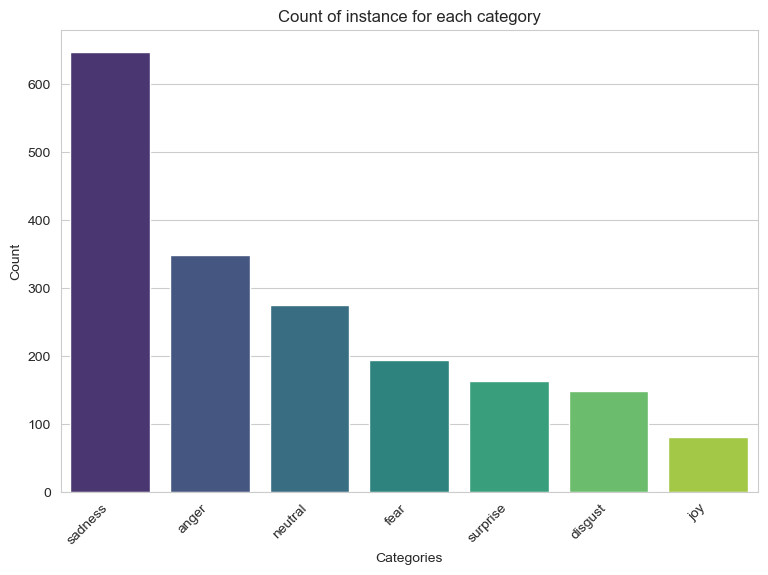

In [116]:
print("Possible sentiments are", np.unique(df_train['emotion']), "of", len(np.unique(df_train['emotion'])),"sentiments")
print("The number of posts for training is", len(df_train))

emotions_count = df_train['emotion'].value_counts()

plt.figure(figsize=(9, 6))
sns.barplot(x=emotions_count.index, y=emotions_count.values,palette='viridis')
plt.title('Count of instance for each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

#split into corpus and target, making target onehot encoded

label_encoder = LabelEncoder()

corpus_train = df_train['essay']
train = label_encoder.fit_transform(df_train['emotion'])
target_train = to_categorical(train, num_classes=len(CATEGORIES))

corpus_val = df_val['essay']
val = label_encoder.fit_transform(df_val['emotion'])
target_val = to_categorical(val, num_classes=len(CATEGORIES))

corpus_test = df_test['essay']
test = label_encoder.fit_transform(df_test['emotion'])
target_test = to_categorical(test, num_classes=len(CATEGORIES))

In [117]:
print(target_train.shape)

(1860, 7)


In [118]:
print(corpus_train.shape)

(1860,)


# Preprocessing

Now we clean up the text to get clean tokens. 1. we only want alphabets and numerics, lowercase 2. tokenization 3. lemmatization 4. remove stop words

In [26]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# write a preprocess function
def clean_text(text):
    cleaned_texts = []
    for row in text:
        row = re.sub(r'[^A-Za-z0-9 ]', '', row) #keep only alphabets, numbers, and space
        row = row.lower() #covert to lower case
        tokens = wordpunct_tokenize(row) #tokenize
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words] #lemmatize and delete stop words
        cleaned_text = ' '.join(tokens)
        cleaned_texts.append(cleaned_text)
    return cleaned_texts

In [103]:
x_train = clean_text(corpus_train)
y_train = target_train

x_val = clean_text(corpus_val)
y_val = target_val

x_test = clean_text(corpus_test)
y_test = target_test

In [115]:
print(x_train.shape())
print(y_train.shape())

AttributeError: 'list' object has no attribute 'shape'

Now it is a good idea to see the text before preprocessing and after preprocessing. Including the total number of unique tokens and 

In [105]:
summary = pd.DataFrame({'original text': [corpus_train[2]],
                        'preprocessed text': [x_train[2]]})
review_len = [sum(1 for word in review.split()) for review in x_train]
tk = [[word for word in review.split()] for review in x_train]
tk_flatten = [token for review in tk for token in review]
tk_num_unique = len(set(tk_flatten))
summary['total tokens'] = np.sum(review_len)
summary['unique tokens'] = tk_num_unique
summary

,original text,preprocessed text,total tokens,unique tokens
0,"no matter what your heritage, you should be ab...",matter heritage able serve country thai herita...,74109,8884


#TF-IDF

In [122]:
EPOCH = 50
BATCHSIZE = 100

In [123]:
vectorizer = TfidfVectorizer(use_idf=True, max_features=900)
tf_idf_train = vectorizer.fit_transform(x_train).toarray()

tf_idf_val = vectorizer.transform(x_val).toarray()
tf_idf_test = vectorizer.transform(x_test).toarray()

In [124]:
#model

model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(tf_idf_train.shape[1],)))
model.add(Dense(7, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
history = model.fit(tf_idf_train, y_train, epochs=EPOCH, batch_size=BATCHSIZE, validation_data=(tf_idf_val, y_val))

Epoch 1/50
19/19 [==============================] - 0s 4ms/step - loss: 1.9359 - accuracy: 0.2118 - val_loss: 1.9111 - val_accuracy: 0.3512
Epoch 2/50
19/19 [==============================] - 0s 1ms/step - loss: 1.8922 - accuracy: 0.3618 - val_loss: 1.8629 - val_accuracy: 0.3602
Epoch 3/50
19/19 [==============================] - 0s 1ms/step - loss: 1.8420 - accuracy: 0.3511 - val_loss: 1.8078 - val_accuracy: 0.3557
Epoch 4/50
19/19 [==============================] - 0s 1ms/step - loss: 1.7878 - accuracy: 0.3484 - val_loss: 1.7532 - val_accuracy: 0.3557
Epoch 5/50
19/19 [==============================] - 0s 1ms/step - loss: 1.7359 - accuracy: 0.3478 - val_loss: 1.7030 - val_accuracy: 0.3557
Epoch 6/50
19/19 [==============================] - 0s 1ms/step - loss: 1.6906 - accuracy: 0.3478 - val_loss: 1.6605 - val_accuracy: 0.3557
Epoch 7/50
19/19 [==============================] - 0s 1ms/step - loss: 1.6509 - accuracy: 0.3484 - val_loss: 1.6208 - val_accuracy: 0.3557
Epoch 8/50
19/19 [==

9/9 [==============================] - 0s 559us/step
          anger  disgust  fear  joy  neutral  sadness  surprise
anger        32        5     0    1        8       24         6
disgust       5        1     1    0        1        4         0
fear          2        0    15    0        6        8         0
joy           2        1     3    0        3        5         0
neutral       6        1     1    2        6        8         1
sadness       7        0     3    1       11       74         2
surprise      2        2     2    0        1        5         2
[[32  5  0  1  8 24  6]
 [ 5  1  1  0  1  4  0]
 [ 2  0 15  0  6  8  0]
 [ 2  1  3  0  3  5  0]
 [ 6  1  1  2  6  8  1]
 [ 7  0  3  1 11 74  2]
 [ 2  2  2  0  1  5  2]]
Confusion matrix is a NumPy array.


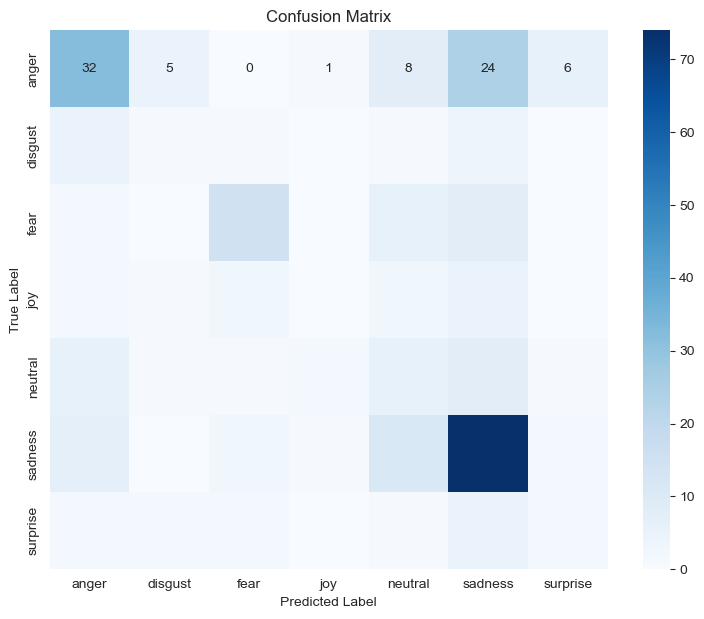


Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.42      0.48        76
           1       0.10      0.08      0.09        12
           2       0.60      0.48      0.54        31
           3       0.00      0.00      0.00        14
           4       0.17      0.24      0.20        25
           5       0.58      0.76      0.65        98
           6       0.18      0.14      0.16        14

    accuracy                           0.48       270
   macro avg       0.31      0.30      0.30       270
weighted avg       0.47      0.48      0.47       270


In [140]:
y_pred = model.predict(tf_idf_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=CATEGORIES.keys(), columns=CATEGORIES.keys())


#print confusion matrix
print(conf_matrix_df)
print(conf_matrix)
if isinstance(conf_matrix, np.ndarray):
    print("Confusion matrix is a NumPy array.")
else:
    print("Confusion matrix is not a NumPy array.")
plt.figure(figsize=(9, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES.keys(), yticklabels=CATEGORIES.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#print classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

In [143]:
def confusionPlot(matrix, normailize=True, title='Confusion Matrix', cmap='Blues'):
    if normailize:
        matrix = matrix.astype('float')/matrix.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(9,7))
    sns.heatmap(matrix, annot=True, fmt='.2f' if normailize else 'd', cmap=cmap)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

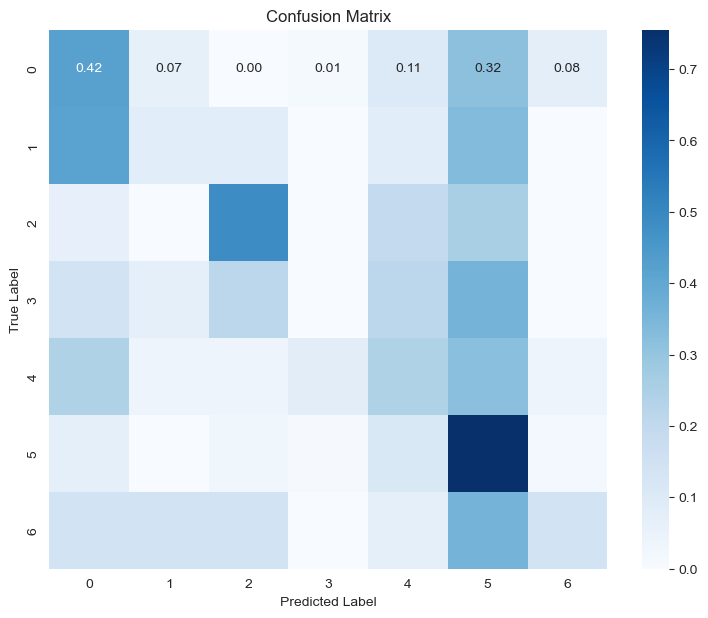

In [146]:
confusionPlot(conf_matrix)

In [147]:
print("Seaborn version:", sns.__version__)

Seaborn version: 0.12.2
